In [342]:
import os
import geocoder
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sqlalchemy import create_engine
from math import sqrt
import plotly.graph_objects as go
import plotly.express as px
from scipy.spatial import KDTree
from scipy.spatial import distance_matrix
from geopy.geocoders import Nominatim
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import Adam
from keras.models import model_from_json
from joblib import dump, load
pd.set_option('display.float_format', lambda x: '%.4f' % x)

### Modules

1. `pandas` for data manipulation in python
2. `sklearn` for the linear regression part for the AVM, the classification models, and the train/test
split, cross-validation, ant standardization
3. `sqlalchemy` to read the data from postgresql
4. `os` to load environment variables (I added the user and pw as env
variables for security reasons)
5. `plotly` for visualization
6. `scipy.spatial` for fast neighbor distance calculation in the point of
interest part
7. `keras` for the Neural network model

# 1. LOADING

In [2]:
# authenticate
user = os.getenv("AVM_USR")
pw = os.getenv("AVM_PW")
db = os.getenv("AVM_DB")
host = "kandula.db.elephantsql.com"
port = 5432

In [3]:
# get data from postgresql
conn = create_engine("postgres://{user}:{pw}@{host}:{port}/{db}".format(
    user=user, pw=pw, host=host, port=port, db=db))
query_listings = "select * from listings"
query_poi = "select * from poi"
listings_df = pd.read_sql_query(
    query_listings,
    conn,
    parse_dates=['meta_valid_from_dts', 'meta_valid_to_dts'])
poi_df = pd.read_sql_query(query_poi, conn)

# 2. PREPROCESSING

In [4]:
listings_df.describe(datetime_is_numeric=True).transpose()

count                           mean  \
web_id                   60000.0000                   6284538.8404   
meta_valid_from_dts           60000  2018-10-27 13:22:39.557883392   
meta_valid_to_dts             60000  2018-11-26 19:16:58.769066496   
offering_type_id         60000.0000                         1.4783   
property_type_id         60000.0000                         1.0000   
bedroom_id               60000.0000                         3.1770   
bathroom_id              60000.0000                         3.8571   
property_sqft            60000.0000                      2334.7371   
property_cheques         18443.0000                         2.9002   
property_price           60000.0000                   1931412.1547   
transacted_after_a_month 59988.0000                         0.1959   
coordinates_lat          60000.0000                        25.0199   
coordinates_lon          60000.0000                        55.0297   

                                          min                  25%  \
web_id                           1904452.0000         6227593.7500   
meta_valid_from_dts       2018-05-20 10:01:01  2018-10-27 17:46:52   
meta_valid_to_dts         2018-11-01 00:00:14  2018-11-05 13:01:16   
offering_type_id                       1.0000               1.0000   
property_type_id                       1.0000               1.0000   
bedroom_id                             1.0000               2.0000   
bathroom_id                            2.0000               3.0000   
property_sqft                          0.0000             882.0000   
property_cheques                       1.0000               1.0000   
property_price                       250.0000          110000.0000   
transacted_after_a_month               0.0000               0.0000   
coordinates_lat                        0.0000              25.0598   
coordinates_lon                        0.0000              55.1486   

                                          50%                  75%  \
web_id                           6386295.5000         6454978.7500   
meta_valid_from_dts       2018-10-27 17:46:52  2018-10-28 13:00:52   
meta_valid_to_dts         2018-11-20 11:33:25  2018-12-06 10:01:11   
offering_type_id                       1.0000               2.0000   
property_type_id                       1.0000               1.0000   
bedroom_id                             3.0000               4.0000   
bathroom_id                            4.0000               5.0000   
property_sqft                       1400.0000            2375.0000   
property_cheques                       2.0000               4.0000   
property_price                    499999.0000         1982791.2500   
transacted_after_a_month               0.0000               0.0000   
coordinates_lat                       25.0894              25.1767   
coordinates_lon                       55.2162              55.2757   

                                          max           std  
web_id                           6498310.0000   293470.8485  
meta_valid_from_dts       2018-10-31 23:01:24           NaN  
meta_valid_to_dts         2019-05-10 02:01:33           NaN  
offering_type_id                       2.0000        0.4995  
property_type_id                       1.0000        0.0000  
bedroom_id                            10.0000        1.4877  
bathroom_id                           10.0000        1.5343  
property_sqft                    3000000.0000    14403.2681  
property_cheques                      12.0000        2.2361  
property_price                1900000000.0000 11470856.4168  
transacted_after_a_month               1.0000        0.3969  
coordinates_lat                       25.3150        1.4950  
coordinates_lon                       55.5450        3.2856

In [5]:
# Number of bedrooms and bathrooms as categorical variables
listings_df[['bedroom_id', 'bathroom_id']].apply(
    {lambda x: str(x)}).describe()

bedroom_id bathroom_id
         <lambda>    <lambda>
count       60000       60000
unique         10           9
top             3           3
freq        16632       18878

In [6]:
# No 1 bathroom listings, 1 bedroom and 2 bathrooms???
print(sorted(listings_df['bedroom_id'].unique()))
print(sorted(listings_df['bathroom_id'].unique()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[2, 3, 4, 5, 6, 7, 8, 9, 10]


In [7]:
# 2774 different locations
# The top location is Dubai, perhaps is a default when no relevant location
# is available
listings_df.location_path_name_primary.describe()

count                                            60000
unique                                            2774
top       Dubai,Downtown Dubai,Burj Vista,Burj Vista 1
freq                                               553
Name: location_path_name_primary, dtype: object

## 2.1. Assumptions and comments

1. I will assume that missing values for property_cheques are 0.
2. Apparently, all listings in this example are of property type 1 (Apartments).
3. The offering types in the date are only two from a total of 4 in the data
 description (Buy and rent).
4. Last feed update seems to be missing, all are empty fields.
5. Latitudes and longitudes of 0 degrees are most likely erroneous values.
6. The model will have issues for predicting new listings that have only 1
bathroom since there is no listings with only one in the entire dataset.
7. Outliers in this scenario most likely come from 4 aspects:

 a. The listing includes the total price of all the apartments in the
 project.
 
 b. The listing contains the total square foot of all the apartments in the
 project.
 
 c. The listing is a test.
 
 d. The listing contains an erroneous price/squared foot.

In [8]:
# Add log of price
listings_df['property_log_price'] = np.log(
    listings_df['property_price']
)
# Add price per square foot
listings_df['property_price_sqft'] = (
    listings_df['property_price'] / 
    listings_df['property_sqft']
)
# Add log of price per square foot
listings_df['property_log_price_sqft'] = np.log(
    listings_df['property_price_sqft']
)

In [9]:
# Change 0 coordinates to missing
listings_df.loc[listings_df.coordinates_lat == 0, 'coordinates_lat'] = np.nan
listings_df.loc[listings_df.coordinates_lon == 0, 'coordinates_lon'] = np.nan
# Remove feed
listings_df = listings_df.drop('feed_last_update', axis=1)

In [10]:
# Replace missing for 0 in property cheques
listings_df.loc[pd.isna(listings_df.property_cheques),
                'property_cheques'] = 0

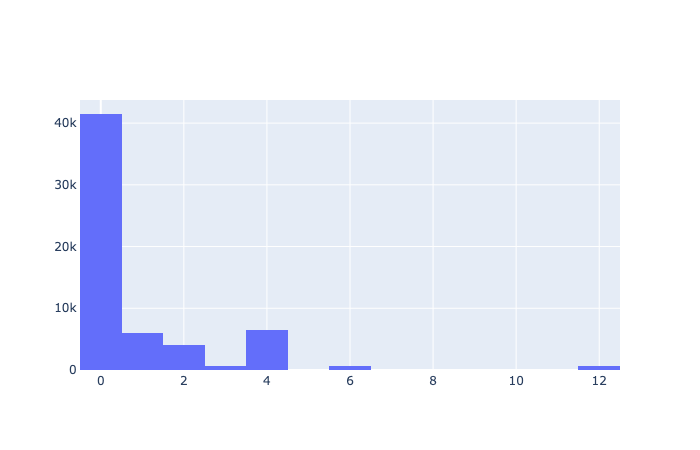

In [11]:
# distribution of property cheques
fig = go.Figure()
fig = fig.add_trace(
    go.Histogram(
        x=listings_df.property_cheques,
    ),
)
fig.show('png')

## 2.2. OUTLIER HANDLING

### 2.3.1 Square foot

In [12]:

# square foot less then 90 seems unrealistic
listings_df = listings_df.loc[listings_df.property_sqft > 90]

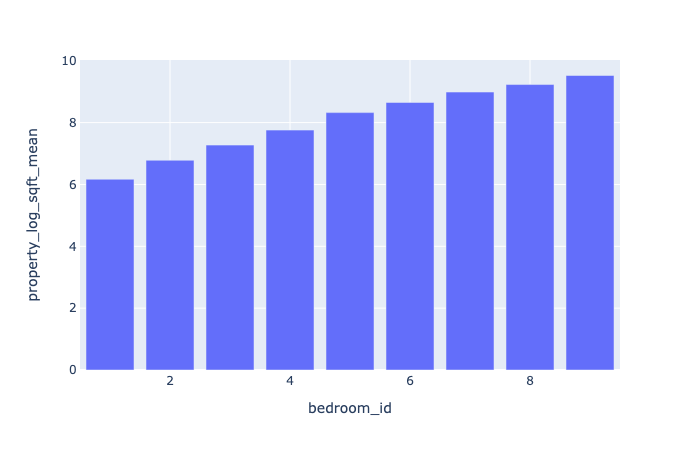

In [208]:
# calculate the average log of square feet a per number of bedrooms
listings_df['property_log_sqft'] = np.log(listings_df['property_sqft'])
grp_bedroom = listings_df.groupby('bedroom_id').agg(
    {'property_log_sqft': ['mean', 'std']}
).reset_index()
col_list = list(grp_bedroom.columns)
col_list = [x[0] + "_" + x[1] if x[1] != '' else x[0] for x in col_list]
grp_bedroom.columns = col_list
fig = px.bar(grp_bedroom, x='bedroom_id', y='property_log_sqft_mean')
fig.show('png')

Now I include this information in the table to identify outliers in terms of the log of square foot
for the apartment relative to the number of bedrooms it has. For example, it doesn't make sense that a
160 square foot (ca. 15 m²) apartment has 3 bedrooms. The idea is to identify and remove them.


In [15]:
listings_df = listings_df.merge(grp_bedroom, on = 'bedroom_id')

In [16]:
listings_df = listings_df.loc[
    ~(listings_df.property_log_sqft <
     listings_df.property_log_sqft_mean -
     3 * listings_df.property_log_sqft_std)
]

In [60]:
listings_df.loc[round(listings_df.property_log_price, 6) == 9.632859, 'location_path_name_primary']

45064    Dubai,Dubai Marina,Princess Tower
Name: location_path_name_primary, dtype: object

### 2.3.2 Price

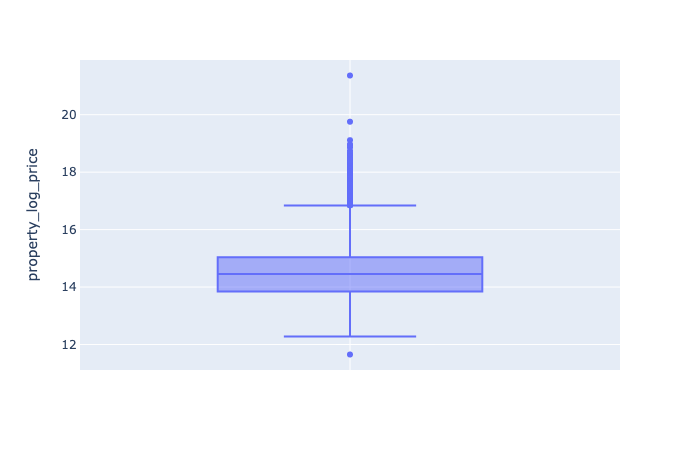

In [17]:
# outliers in price for sale
fig = px.box(
    listings_df.loc[listings_df.offering_type_id == 1],
    y="property_log_price")
fig.show('png')

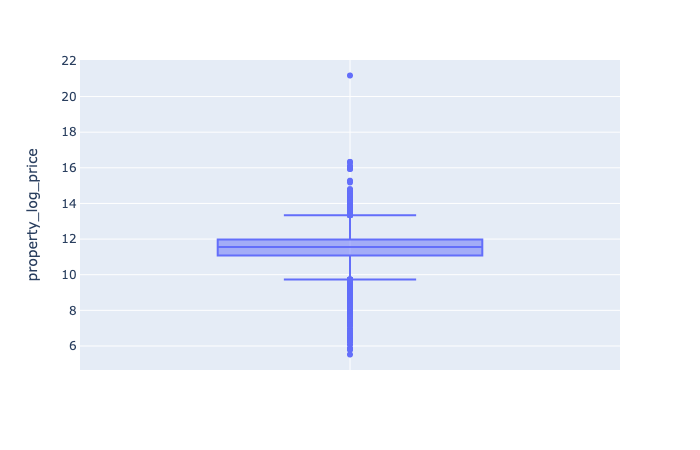

In [18]:
# outlier in price for rent
fig = px.box(
    listings_df.loc[listings_df.offering_type_id == 2],
    y="property_log_price")
fig.show('png')

In [19]:
# Remove extreme outliers
listings_df = listings_df.loc[listings_df.property_log_price < 17]
listings_df = listings_df.loc[
    ~((listings_df.offering_type_id == 2) &
      ((listings_df.property_log_price < 9.6) |
       (listings_df.property_log_price > 14)))
]

#### 2.3.1.1 Reasoning for outlier removal
After some time investigating the price ranges in the Property
finder website I noticed that there are entire floors or even entire
buildings for sale. Since we don't have this information here as an
additional variable is hard to draw the price line for some luxury apartments
vs an entire floor of apartments.

Thinking about the business application of a model such as this one, there
should be a different category for these kinds of listings, since the number of
beds and bathrooms corresponds to a single apartment. Also, I would think that
the type of client for buildings and/or entire floors is different from
single apartment ones.

Based on this I will exclude prices above 24,154,953 AED. This probably will
probably remove all entire floors but also some high luxury apartments.
Since I currently have no way of differentiate them, I will just reduce the
scope of the model to prices no bigger than this amount.

For rent, there are several outliers with prices below 9000 AED. I think in
the past the app allowed to list the rent price per month and this could be
related to these small prices. Even more so, there are some that really don't
make sense to me, like 500 AED or less?. For the purposes of the model I will
restrict the scope again to rent prices above 14.900 AED and below 1,202,604 AED.

### 2.3.2  price per square foot

In [20]:
# the following listings have an extremely high price per squared foot
# By the number of bedrooms and bathroom these values don't make sense
listings_df = listings_df.loc[~((listings_df.property_log_price_sqft  > 10) &
                (listings_df.property_sqft  < 130))]
# Also more than 3 bedroom in less than 500 square foot doesn't make sense
# so I will also drop this values
listings_df = listings_df.loc[~((listings_df.property_sqft <= 500) &
               (listings_df.bedroom_id > 3))]

## 2.3 Log of Price distribution by offering type 

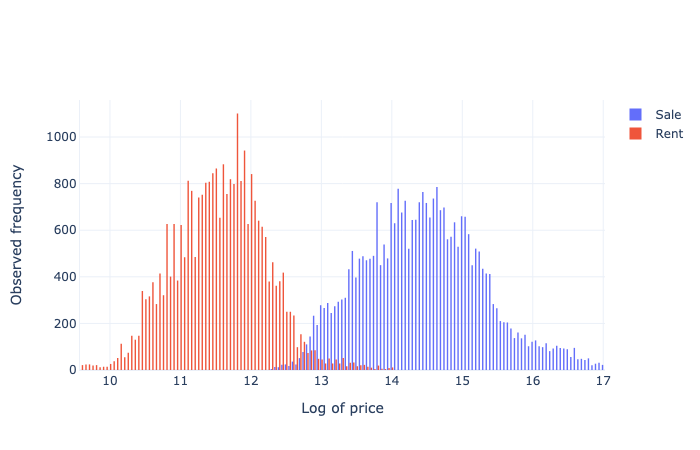

In [21]:
log_price_offering_1 = listings_df.loc[
    listings_df['offering_type_id'] == 1]['property_log_price']
log_price_offering_2 = listings_df.loc[
    listings_df['offering_type_id'] == 2]['property_log_price']
log_price_viz_obj = go.Figure()
log_price_viz_obj = log_price_viz_obj.add_trace(
    go.Histogram(
        x=log_price_offering_1,
        name="Sale"
    )
)
log_price_viz_obj = log_price_viz_obj.add_trace(
    go.Histogram(
        x=log_price_offering_2,
        name="Rent"
    )
)
log_price_viz_obj.update_layout(
    template="plotly_white",
    xaxis={
        "title": "Log of price"
    },
    yaxis={
        "title": "Observed frequency"
    }
)
log_price_viz_obj.show('png')

### 2.2.1 Comments

We can see that the offering type plays an important role for the price
distribution since:

The distribution of the log prices for all listings shows a bimodal  behavior
(two different peaks), hinting that two clearly different groups are present

Once I include the offering type, the distribution of each of the two types matches
each of the distributions

## 2.4 Missing lat - long imputation
I will use the `geopy` and `geocoder` modules to estimate the missing
coordinates using the location name

In [22]:
# get all locations with missing coordinates
distinct_locations_no_coords = set(listings_df.loc[
    pd.isna(listings_df.coordinates_lat),
    'location_path_name_primary'].unique())

In [23]:
geo_locator = Nominatim(user_agent="http")
new_coords = {
    x: {"lat": np.nan, "lon": np.nan} 
    for x in distinct_locations_no_coords
}
for loc in distinct_locations_no_coords:
    location = geo_locator.geocode(loc)
    if location:
        new_coords[loc]['lat'] = location.latitude
        new_coords[loc]['lon'] = location.longitude
    else:
        location = geocoder.google(
            loc,
            key=os.getenv("GMAPS_API")
        )
        print(location)
        if location.latlng:
            new_coords[loc]['lat'] = location.latlng[0]
            new_coords[loc]['lon'] = location.latlng[1]
        else:
            print("Not found " + loc) 

<[OK] Google - Geocode [JVC - Jumeirah Village - Dubai - United Arab Emirates]>
<[OK] Google - Geocode [Jumeirah Village Circle - Jumeirah Village - Dubai - United Arab Emirates]>
<[OK] Google - Geocode [Dubai - Liwan - Dubai - United Arab Emirates]>
<[OK] Google - Geocode [Dubai Production City - Dubai - United Arab Emirates]>
<[OK] Google - Geocode #2 results>
<[OK] Google - Geocode [Al WarqaAl Warqa 1 - Dubai - United Arab Emirates]>
<[OK] Google - Geocode [Dubai - Ras Al KhorDubai Creek Harbour - Dubai - United Arab Emirates]>
<[OK] Google - Geocode [Downtown Jabel Ali, Near UAE Exchange Metro Station - Jebel Ali Freezone Extension - Dubai - United Arab Emirates]>
<[OK] Google - Geocode [Dubai - Jumeirah Village - Dubai - United Arab Emirates]>
<[OK] Google - Geocode [District 3 - Jumeirah VillageJumeirah Village Triangle - Dubai - United Arab Emirates]>
<[OK] Google - Geocode [The World Islands - Dubai - United Arab Emirates]>
<[OK] Google - Geocode [Dubai - Dubai Silicon Oasis - 

In [24]:
for coord in new_coords:
    listings_df.loc[
        (pd.isna(listings_df.coordinates_lat)) &
        (listings_df.location_path_name_primary == coord),
        'coordinates_lat'] = new_coords[coord]['lat']
    listings_df.loc[
        (pd.isna(listings_df.coordinates_lon)) &
        (listings_df.location_path_name_primary == coord),
        'coordinates_lon'] = new_coords[coord]['lon']

In [25]:
# now the latitude and longitude is valid for all listings
listings_df[['coordinates_lat', 'coordinates_lon']].describe().transpose()

count    mean    std     min     25%     50%     75%  \
coordinates_lat 58752.0000 25.1087 0.0689 24.8456 25.0597 25.0894 25.1771   
coordinates_lon 58752.0000 55.2262 0.0784 54.9735 55.1487 55.2172 55.2758   

                    max  
coordinates_lat 25.3150  
coordinates_lon 55.5450

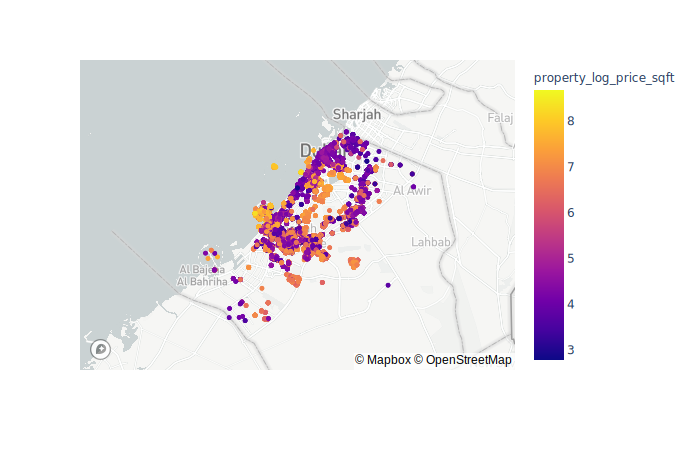

In [26]:
# Visualize log price per square foot on the map
# for this I only select values within 2 standard deviations of the mean
# since extreme values will affect the color coding
avg_price_sqft = listings_df.property_log_price_sqft.mean()
sd_price_sqft = listings_df.property_log_price_sqft.std()
upper_limit = avg_price_sqft + 2 * sd_price_sqft
lower_limit = avg_price_sqft - 2 * sd_price_sqft
px.set_mapbox_access_token(os.getenv('MAPBOX_TOKEN')
    )
fig = px.scatter_mapbox(
    listings_df.loc[
        (listings_df.property_log_price_sqft < upper_limit) &
        (listings_df.property_log_price_sqft > lower_limit)
    ],
    lat="coordinates_lat",
    lon="coordinates_lon",
    color="property_log_price_sqft")
fig.show('svg')

## 2.5 Listing version intervals
First I will round the timestamps to days
Then I will look at the number of listings every day as a time series
Finally I will look at the average price as a time series as well

In [27]:
# aggregate log price per square foot by meta_valid_from_dts
# or meta_valid_to_dts and visualize
def price_viz(ts_var):
    grp = listings_df.groupby(
        ['offering_type_id', ts_var]
    ).agg(
        {'property_log_price': 'mean'}
    ).reset_index()
    price_viz_obj = go.Figure()
    price_viz_obj = price_viz_obj.add_trace(
        go.Scatter(
            x=grp.loc[grp.offering_type_id == 1,
                      ts_var],
            y=grp.loc[grp.offering_type_id == 1,
                'property_log_price'],
            mode='lines',
            name='Sale',
            line=dict(color='#73d700')
        )
    )
    price_viz_obj = price_viz_obj.add_trace(
        go.Scatter(
            x=grp.loc[grp.offering_type_id == 2,
                      ts_var],
            y=grp.loc[grp.offering_type_id == 2,
                'property_log_price'],
            mode='lines',
            name='Rent',
            line=dict(color='#ffad00')
        )
    )
    x_title = (ts_var == "meta_valid_from_dts" and "from" or "to")
    price_viz_obj = price_viz_obj.update_layout(
        template="plotly_white",
        xaxis={
            "title": "Listing version valid" + x_title + " this date"},
        yaxis={
            "title": "Average property price (AED)"
        }
    )
    price_viz_obj.show('png')


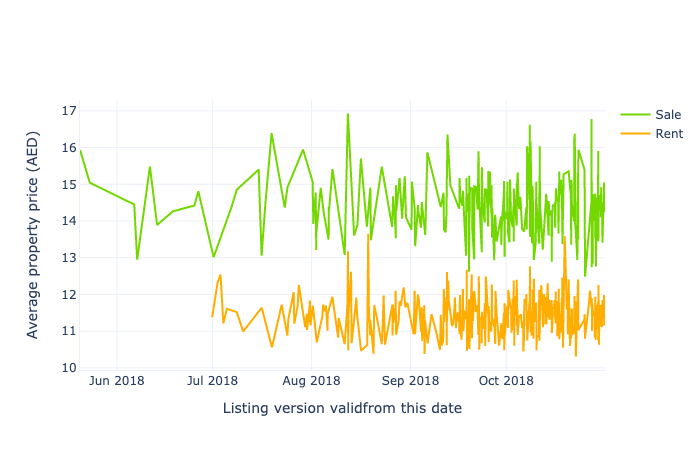

In [28]:
price_viz('meta_valid_from_dts')

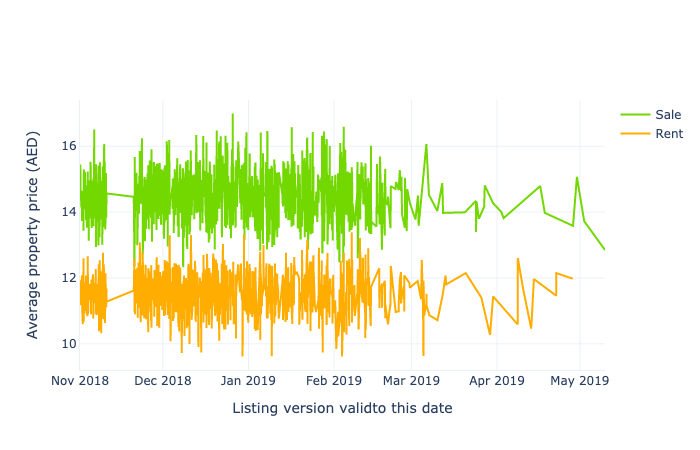

In [29]:
price_viz('meta_valid_to_dts')

In [30]:
def count_viz(ts_var):
    grp = listings_df.groupby(
        ['offering_type_id', ts_var]
    ).agg(
        {'web_id': 'count', 'property_price': np.mean}
    ).reset_index()
    viz_count_obj = go.Figure()
    viz_count_obj = viz_count_obj.add_trace(
        go.Scatter(
            x=grp.loc[grp.offering_type_id == 1,
                      ts_var],
            y=grp.loc[grp.offering_type_id == 1,
                'web_id'],
            mode='lines',
            name='Sale',
            line=dict(color='#73d700')
        )
    )
    viz_count_obj = viz_count_obj.add_trace(
        go.Scatter(
            x=grp.loc[grp.offering_type_id == 2,
                      ts_var],
            y=grp.loc[grp.offering_type_id == 2,
                'web_id'],
            mode='lines',
            name='Rent',
            line=dict(color='#ffad00')
        )
    )
    x_title = (ts_var == 'meta_valid_from_dts' and 'from' or 'to')
    viz_count_obj = viz_count_obj.update_layout(
        template="plotly_white",
        xaxis={
            "title": "Listing version valid " + x_title + " this date"},
        yaxis={
            "title": "Number of listings at specific time"
        }
    )
    viz_count_obj.show('png')

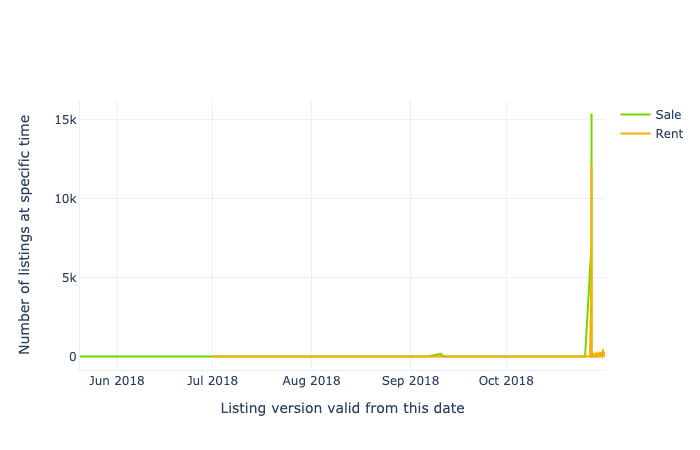

In [31]:
# Check number of listings by offering type 
count_viz('meta_valid_from_dts')

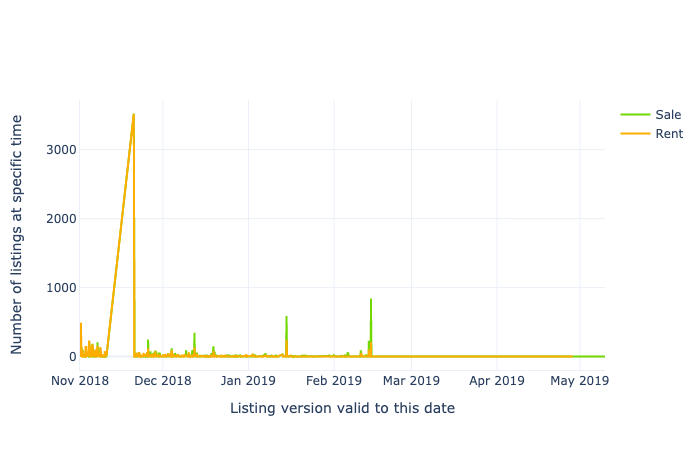

In [32]:
# the peaks here are not the same size as in valid from
# meaning that they don't have exactly the same valid to timestamp
count_viz('meta_valid_to_dts')

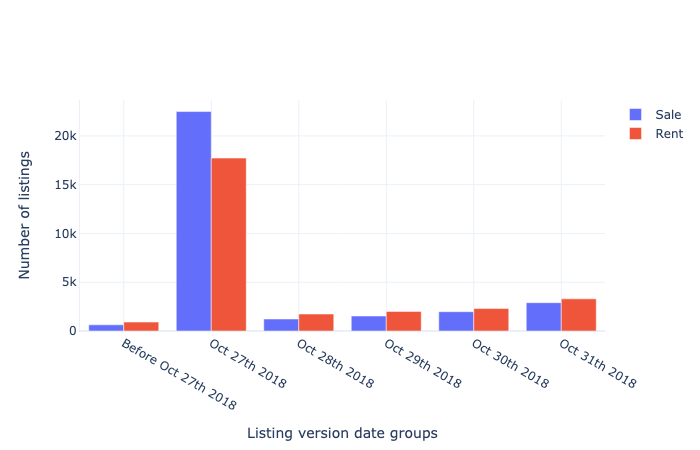

In [223]:
# Let's group before october 27, october 27, 28, 29, 30
cond_list = [
    listings_df.meta_valid_from_dts < '2018-10-27',
    ((listings_df.meta_valid_from_dts >= '2018-10-27') &
     (listings_df.meta_valid_from_dts < '2018-10-28')),
    ((listings_df.meta_valid_from_dts >= '2018-10-28') &
     (listings_df.meta_valid_from_dts < '2018-10-29')),
    ((listings_df.meta_valid_from_dts >= '2018-10-29') &
     (listings_df.meta_valid_from_dts < '2018-10-30')),
    ((listings_df.meta_valid_from_dts >= '2018-10-30') &
     (listings_df.meta_valid_from_dts < '2018-10-31')),
]
choice_list = [
    'Before Oct 27th 2018',
    'Oct 27th 2018',
    'Oct 28th 2018',
    'Oct 29th 2018',
    'Oct 30th 2018',
]
listings_df['ts_groups_from'] = np.select(
    cond_list, choice_list,
    default='Oct 31th 2018')
grp_bar_from = listings_df.groupby(
    ['offering_type_id','ts_groups_from']
).agg(
    {'web_id': 'count', 'property_price': np.mean}
).reset_index()
fig = go.Figure(
    data=[
        go.Bar(
            x=grp_bar_from.loc[
                grp_bar_from.offering_type_id == 1,
                'ts_groups_from'],
            y=grp_bar_from.loc[
                grp_bar_from.offering_type_id == 1,
                'web_id'],
            name='Sale'
        ),
        go.Bar(
            x=grp_bar_from.loc[
                grp_bar_from.offering_type_id == 2,
                'ts_groups_from'],
            y=grp_bar_from.loc[
                grp_bar_from.offering_type_id == 2,
                'web_id'],
            name='Rent'
        )
    ],
                
)
fig = fig.update_layout(
    template="plotly_white",
    barmode='group',
    xaxis={
        "title": "Listing version date groups"},
    yaxis={
        "title": "Number of listings"
    }
)
fig.show('png')

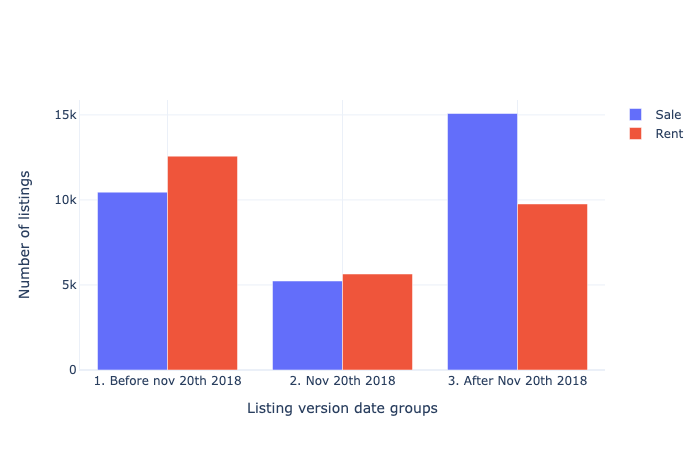

In [221]:
# Let's group before october 27, october 27, 28, 29, 30
cond_list = [
    listings_df.meta_valid_to_dts < '2018-11-20',
    ((listings_df.meta_valid_to_dts >= '2018-11-20') &
     (listings_df.meta_valid_to_dts < '2018-11-21'))
]
choice_list_to = [
    '1. Before nov 20th 2018',
    '2. Nov 20th 2018'
]
listings_df['ts_groups_to'] = np.select(
    cond_list, choice_list_to,
    default='3. After Nov 20th 2018')
grp_bar_to = listings_df.groupby(
    ['offering_type_id','ts_groups_to']
).agg(
    {'web_id': 'count', 'property_price': np.mean}
).reset_index()
fig = go.Figure(
    data=[
        go.Bar(
            x=grp_bar_to.loc[
                grp_bar_to.offering_type_id == 1,
                'ts_groups_to'],
            y=grp_bar_to.loc[
                grp_bar_to.offering_type_id == 1,
                'web_id'],
            name='Sale'
        ),
        go.Bar(
            x=grp_bar_to.loc[
                grp_bar_to.offering_type_id == 2,
                'ts_groups_to'],
            y=grp_bar_to.loc[
                grp_bar_to.offering_type_id == 2,
                'web_id'],
            name='Rent'
        )
    ],
                
)
fig = fig.update_layout(
    template="plotly_white",
    barmode='group',
    xaxis={
        "title": "Listing version date groups"},
    yaxis={
        "title": "Number of listings"
    }
)
fig.show('png')

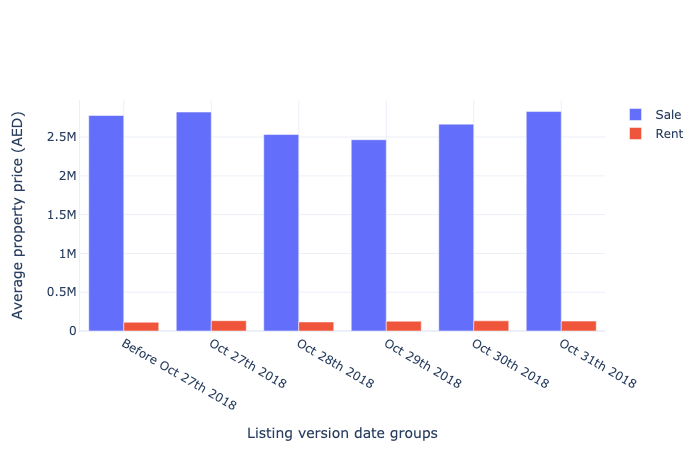

In [222]:
# price average for the different groups
fig = go.Figure(
    data=[
        go.Bar(
            x=grp_bar_from.loc[
                grp_bar_from.offering_type_id == 1,
                'ts_groups_from'],
            y=grp_bar_from.loc[
                grp_bar_from.offering_type_id == 1,
                'property_price'],
            name='Sale'
        ),
        go.Bar(
            x=grp_bar_from.loc[
                grp_bar_from.offering_type_id == 2,
                'ts_groups_from'],
            y=grp_bar_from.loc[
                grp_bar_from.offering_type_id == 2,
                'property_price'],
            name='Rent'
        )
    ],
                
)
fig = fig.update_layout(
    template="plotly_white",
    barmode='group',
    xaxis={
        "title": "Listing version date groups"},
    yaxis={
        "title": "Average property price (AED)"
    }
)
fig.show('png')

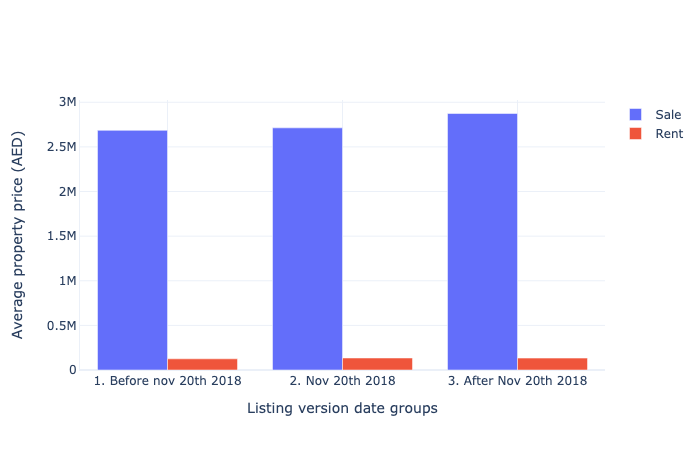

In [218]:
# price average for the different groups
fig = go.Figure(
    data=[
        go.Bar(
            x=grp_bar_to.loc[
                grp_bar_to.offering_type_id == 1,
                'ts_groups_to'],
            y=grp_bar_to.loc[
                grp_bar_to.offering_type_id == 1,
                'property_price'],
            name='Sale'
        ),
        go.Bar(
            x=grp_bar_to.loc[
                grp_bar_to.offering_type_id == 2,
                'ts_groups_to'],
            y=grp_bar_to.loc[
                grp_bar_to.offering_type_id == 2,
                'property_price'],
            name='Rent'
        )
    ],
                
)
fig = fig.update_layout(
    template="plotly_white",
    barmode='group',
    xaxis={
        "title": "Listing version date groups"},
    yaxis={
        "title": "Average property price (AED)"
    }
)
fig.show('png')

In [37]:
# listing valid period
listings_df['valid_period'] = (
    listings_df['meta_valid_to_dts'] -
    listings_df['meta_valid_from_dts']
)
listings_df['valid_period'] = listings_df['valid_period']\
   .apply(lambda x: round(x.total_seconds() / (60*60*24*30.4167), 2))

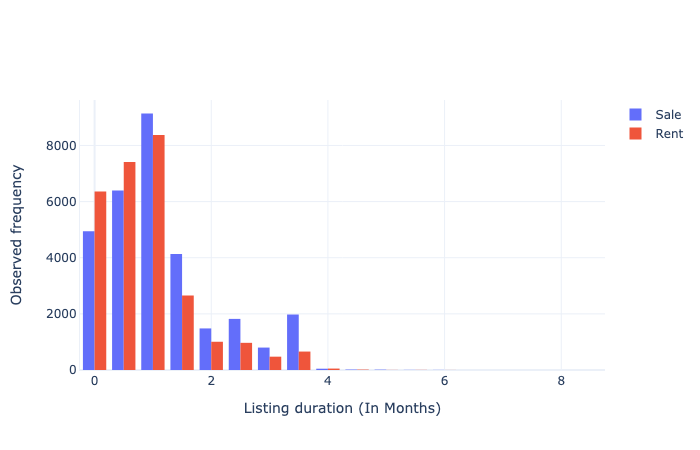

In [38]:
fig = go.Figure()
fig = fig.add_trace(
    go.Histogram(
        x=listings_df.loc[
            listings_df.offering_type_id == 1,
            'valid_period'],
        name="Sale",
        autobinx=False,
        nbinsx=40
    ),
)
fig = fig.add_trace(
     go.Histogram(
         x=listings_df.loc[
             listings_df.offering_type_id == 2,
             'valid_period'],
         name="Rent",
         autobinx=False,
         nbinsx=40
     )
 )
fig.update_layout(
    template="plotly_white",
    xaxis={
        "title": "Listing duration (In Months)"
    },
    yaxis={
        "title": "Observed frequency"
    }
)
fig.show('png')

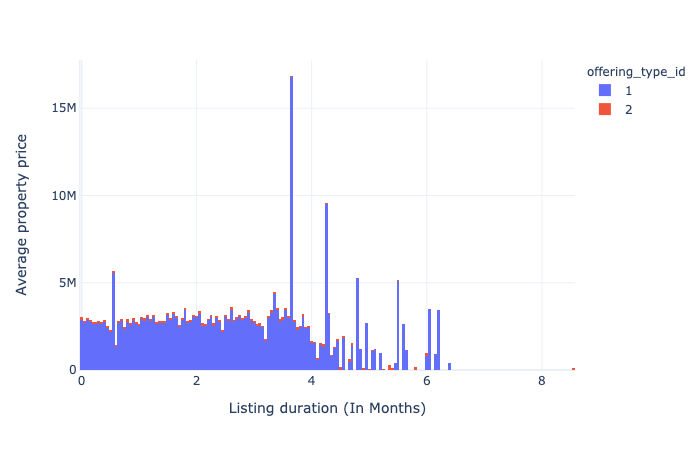

In [39]:
# avg price by duration
fig = px.histogram(
    listings_df,
    x="valid_period",
    y="property_price",
    color="offering_type_id",
    histfunc='avg')
fig.update_layout(
    template="plotly_white",
    xaxis={
        "title": "Listing duration (In Months)"
    },
    yaxis={
        "title": "Average property price"
    }
)
fig.show('png')

### 2.5.1 Conclusions
1. There is a significant high number of listings valid from 2 particular
 timestamps (2018-10-27 at 17:36 and 17:46). This could mean the data before
  didn't have a time stamp? a massive import from another system? Not all of
  them have the same valid to timestamp, so a default value is not likely.
3. From the two variables we can see that valid from date impacts price the most
(This is intuitive since the price depends from on the starting date of the
listing and not the end). I will use these groups as features in the model.
4. For the listings valid period we can see some specific periods with higher
 average price, so the model could benefit from this (If it makes sense to
 add it, assuming new values to be predicted will have all these features)

# 3. Model

## 3.1 Regression Models
### 3.1.1 First simple baseline model
Before adding complexities like the distance to the landmarks found in the
other table or time parameters for the time when the listing was valid I will
  fit a first linear regression
### 3.1.1.1 Note on assumptions
Some characteristics in the table seem to be unavailable for new
observations. I'm not sure features would be available in a real world
scenario.  For now, I'll use all features.


In [40]:
# one hot encode for the valid from variable groups
new_vars = pd.get_dummies(listings_df.ts_groups_from)
columns = list(new_vars.columns)
new_vars.columns = [x.lower().replace(' ', '_') for x in columns]
listings_df = listings_df.join(new_vars)

In [72]:
y = listings_df.property_log_price
covariates = [
    'offering_type_id',
    'bedroom_id',
    'bathroom_id',
    'property_log_sqft',
    'property_cheques',
    'valid_period',
] + list(new_vars.columns)
X = listings_df[covariates]

In [73]:
# split in train test using 70/30 split
X_train, X_test, y_train, y_test = train_test_split(
                          X, y, random_state=32, test_size=.30)
lr_model_def = linear_model.LinearRegression()
lm_model = lr_model_def.fit(X_train, y_train)
lm_preds = lm_model.predict(X_test)
final_preds = np.exp(lm_preds)
# R^2 for test set
print("R^2: ", round(lm_model.score(X_test, y_test), 2))
y_test = np.exp(y_test)
print(
    "RMSE: ",
    round(sqrt(mean_squared_error(y_test, final_preds)), 2),
    "AED")

R^2:  0.94
RMSE:  1383451.84 AED


In [74]:
fig = go.Figure()
fig = fig.add_trace(
    go.Scatter(
        x=lm_preds,
        y=np.log(y_test),
        mode='markers',
        line=dict(color='#73d700')
    )
)
fig = fig.update_layout(
    template="plotly_white",
    xaxis={
        "title": "Predicted Log Price"
    },
    yaxis={
        "title": "Actual  Log Price"
    }
)
fig.show('svg')

### 3.1.1 Comments on first baseline model
The model explains 94% of the variance found in the loc of price (target
variable). Nevertheless, we can see that the naive model makes the same
prediction for different actual values (In the chart it looks like vertical
lines). This implies that the model can definitively benefit from including
more information.

## 3.2 Add points of interest as features
One approach to use the geolocation of the listings is to calculate the
distance to specific landmarks (schools, malls, etc.)

For this I will use the euclidean distance to elements of the second table
provided for the test

In [75]:
poi_df.describe().transpose()

count    mean    std     min     25%     50%     75%     max
lat 77.0000 25.1545 0.1016 24.8903 25.0765 25.1910 25.2490 25.2780
lon 77.0000 55.2459 0.0993 54.9904 55.1506 55.2765 55.3230 55.4078

In [76]:
print(poi_df.category.unique())
poi_df.category.describe()

['Landmark' 'Metro' 'Tram']


count        77
unique        3
top       Metro
freq         47
Name: category, dtype: object

I will add 2 new simple features:

1. Distance to the nearest tram.
2. Distance to the nearest metro.

Also, since I assume not all landmarks are the same I will add the distance to each of them as features.
This will help to group listings that are close together using these new features as something like a
triangulation points. This is a simple approach, more advanced techniques like spatial regression could be used.
Also, the assumption is that there is a correlation between proximity to tram and/or metro stations and listing the
price.For the landmarks on the other hand it helps to group listings with similar distance to multiple landmarks as
neighbors (If they are close together, all landmark distances should be similar)

In [77]:
def nearest_poi(listings, poi, poi_type):
    cat_df = poi.loc[poi.category == poi_type].reset_index()
    tree = KDTree(
        cat_df[['lat', 'lon']].values
    )
    neighbor_dists, neighbor_indices = tree.query(
         listings[
            ['coordinates_lat', 'coordinates_lon']
        ].values
    )
    return neighbor_dists


In [78]:
# Distance to nearest metro and tram station
listings_df['metro_poi'] = nearest_poi(
    listings_df, poi_df, 'Metro')
listings_df['tram_poi'] = nearest_poi(
    listings_df, poi_df, 'Tram')

In [82]:
# distance to all landmarks
landmark_df = poi_df.loc[poi_df.category == 'Landmark'].reset_index()
all_dists = distance_matrix(
    listings_df[
        ['coordinates_lat',
         'coordinates_lon']
    ].values,
    landmark_df[['lat', 'lon']].values
)
new_att = pd.DataFrame(all_dists)
new_att.columns = [
    x.lower().replace(' ', '_')
    for x in list(landmark_df.name)
]
landmark_features = list(new_att.columns)
new_att.index = listings_df.index
#listings_df = listings_df.drop(list(new_att.columns), axis=1)
listings_df = listings_df.join(new_att)

With these new covariates I generate a new set of features

In [83]:
# New set of features
new_covs = covariates + ['metro_poi', 'tram_poi'] + landmark_features
X = listings_df[new_covs]

In [84]:
X.columns

Index(['offering_type_id', 'bedroom_id', 'bathroom_id', 'property_log_sqft',
       'property_cheques', 'valid_period', 'before_oct_27th_2018',
       'oct_27th_2018', 'oct_28th_2018', 'oct_29th_2018', 'oct_30th_2018',
       'oct_31th_2018', 'metro_poi', 'tram_poi', 'expo_2020_site',
       'marina_mall', 'hamdan_sports_complex', 'motor_city', 'jabel_ali',
       'img_world_adventures', 'dubai_parks_and_resorts',
       'dubai_cycling_course', 'sports_city_and_dubai_swimming_academy',
       'downtown_dubai', 'global_village', 'dubai_mall', 'mirdif_city_centre',
       'ibn_battuta_mall', 'burj_al_arab', 'dubai_internatial_airport_(dxb)',
       'al_maktoum_international_airport_(dwc)', 'mall_of_the_emirates',
       'burj_khalifa'],
      dtype='object')

I split again in train and test sets using the same random seed to compare with previous model

In [86]:
# split in train test using 70/30 split
X_train, X_test, y_train, y_test = train_test_split(
                          X, y, random_state=32, test_size=.30)
lr_model_def = linear_model.LinearRegression()
lm_model = lr_model_def.fit(X_train, y_train)
lm_preds = lm_model.predict(X_test)
final_preds = np.exp(lm_preds)


R^2:  0.96
RMSE:  1129332.94 AED


In [201]:
# More in depth, let's look at the errors for each offering type
final_preds = pd.Series(final_preds)
lm_preds = pd.Series(lm_preds)
final_preds.index = X_test.index
lm_preds.index = X_test.index
y_test_sale = np.exp(y_test[X_test.index[X_test.offering_type_id == 1]])
y_test_rent = np.exp(y_test[X_test.index[X_test.offering_type_id == 2]])
lm_preds_sale = lm_preds[X_test.index[X_test.offering_type_id == 1]]
lm_preds_rent = lm_preds[X_test.index[X_test.offering_type_id == 2]]
final_preds_sale = final_preds[X_test.index[X_test.offering_type_id == 1]]
final_preds_rent = final_preds[X_test.index[X_test.offering_type_id == 2]]

In [202]:
# R^2 for test set
print("R^2: ", round(lm_model.score(X_test, y_test), 2))
print(
    "RMSE All listings: ",
    round(sqrt(mean_squared_error(np.exp(y_test), final_preds)), 2),
    "AED")
print(
    "RMSE Sale: ",
    round(sqrt(mean_squared_error(y_test_sale, final_preds_sale)), 2),
    "AED")
print(
    "RMSE Rent: ",
    round(sqrt(mean_squared_error(y_test_rent, final_preds_rent)), 2),
    "AED")

R^2:  0.96
RMSE All listings:  1129332.94 AED
RMSE Sale:  1553135.88 AED
RMSE Rent:  72628.85 AED


In [204]:
# Add MAPE error for correct comparison between offering types
print(
    "MAPE All Listings: ",
    round(
        np.mean(
            np.abs(
                (np.exp(y_test) - final_preds) / np.exp(y_test))
        ) * 100,
        2),
    "%")
print(
    "MAPE Sale: ",
    round(
        np.mean(
            np.abs(
                (y_test_sale - final_preds_sale) / y_test_sale)
        ) * 100,
        2),
    "%")
print(
    "MAPE Rent: ",
    round(
        np.mean(
            np.abs(
                (y_test_rent - final_preds_rent) / y_test_rent)
        ) * 100,
        2),
    "%")

MAPE All Listings:  24.1 %
MAPE Sale:  22.98 %
MAPE Rent:  25.35 %


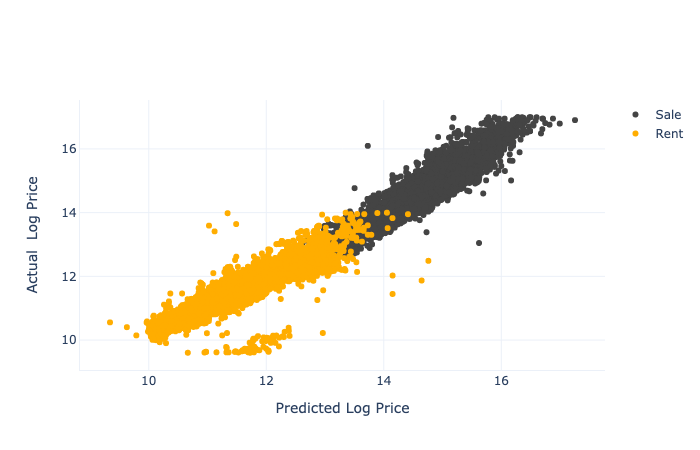

In [209]:
fig = go.Figure()
fig = fig.update_layout(
    template="plotly_white",
    xaxis={
        "title": "Predicted Log Price"
    },
    yaxis={
        "title": "Actual  Log Price"
    }
)
fig = fig.add_trace(
    go.Scatter(
        x=lm_preds_sale,
        y=np.log(y_test_sale),
        mode='markers',
        name='Sale',
        line=dict(color='#444444')
    )
)
fig = fig.add_trace(
    go.Scatter(
        x=lm_preds_rent,
        y=np.log(y_test_rent),
        mode='markers',
        name='Rent',
        line=dict(color='#ffad00')
    )
)

fig.show('png')

### 3.2.1 Comments on second model

The model explains 96% of the variance, a 2% increase in terms of the
baseline model. Based on the chart and the reduction of the RMSE, there is a
significant improvement in the predictions by incorporating the minimum
distance to metro and tram and the distance to all landmarks. Also, we can see
that the model is failing most for the offering type 2 (rent) according to
the MAPE.  
Visually, it looks like there are still outliers in the
rent offering. With more time, I would make a more substantial exploration
of those values to understand why they are being overestimated. Most likely
they correspond to luxury apartments with a rent price for a single month or
at least different from a year. These types of outliers are not straightforward
to remove. One approach would be to remove them base on these results.

## 3.3 Neural Network model
In order to take advantage of possible complex non-linear relationships
between features and dependent variable, I will fit a neural network
model with the same features


In [90]:
y = listings_df.property_log_price
X = listings_df[new_covs]

X_train, X_test, y_train, y_test = train_test_split(
                          X, y, random_state=32, test_size=.30)

### 3.3.1 Network architecture
Network approach:
- 1 input layer with the number of columns in the training set as neurons
- 3 hidden layers with 660 (33 features times 20) of neurons and leaky relu activation function
- Output layer with a single neuron and linear activation function for the
regression (since in this case we are predicting a single variable)

Reasoning: I tried simpler architectures, and the network failed to learn. I used this architecture based on
the fact that is an approach that has usually worked before for me without hyperparameter tuning. If I had more time
I would do an actual hyperparameter tuning (Learning rate, batch size, number of hidden layers, size of the layers,
etc.)

In [91]:

def bl_nn():
    optimizer = Adam(0.0001)
    model = Sequential()
    model.add(
        Dense(
            X_train.shape[1] * 20,
            input_dim=X_train.shape[1],
            kernel_initializer='normal')
    )
    model.add(LeakyReLU())
    model.add(
        Dense(
            X_train.shape[1] * 20,
            kernel_initializer='normal')
    )
    model.add(LeakyReLU())
    model.add(
        Dense(X_train.shape[1] * 20,
              kernel_initializer='normal')
    )
    model.add(LeakyReLU())
    model.add(
        Dense(1, kernel_initializer='normal')
    )
    model.compile(
        loss='mean_squared_error',
        optimizer=optimizer
    )
    return model

def train_data_nn(features, dep_var):
    np.random.seed(42)
    # create model
    reg_def = KerasRegressor(
        build_fn=bl_nn, epochs=100,
        batch_size=10, verbose=1
    )
    k_fold = KFold(n_splits=10, random_state=42, shuffle=True)
    results = cross_val_score(reg_def, features, dep_var, cv=k_fold)
    print("Standardized: %.2f (%.2f) MSE" % 
          (-results.mean(), results.std()))
    return reg_def



In [92]:
# The average MSE in the 10-fold cross-validation is 0.06
# The standard deviation is 0.01
scaler = StandardScaler().fit(X_train)
X_train_st = scaler.transform(X_train)

X_test_st = scaler.transform(X_test)
estimator = train_data_nn(X_train_st, y_train)

In [95]:
nn_trained = estimator.fit(
    X_train_st, y_train, validation_split=0.1,
    epochs=200, batch_size=10,
    verbose=1)

Epoch 1/200
3702/3702 [==============================] - 15s 4ms/step - loss: 1.3584 - val_loss: 0.1507
Epoch 2/200
3702/3702 [==============================] - 15s 4ms/step - loss: 0.1340 - val_loss: 0.1057
Epoch 3/200
3702/3702 [==============================] - 16s 4ms/step - loss: 0.1158 - val_loss: 0.1343
Epoch 4/200
3702/3702 [==============================] - 16s 4ms/step - loss: 0.1051 - val_loss: 0.1152
Epoch 5/200
3702/3702 [==============================] - 17s 5ms/step - loss: 0.1008 - val_loss: 0.1048
Epoch 6/200
3702/3702 [==============================] - 16s 4ms/step - loss: 0.0961 - val_loss: 0.0838
Epoch 7/200
3702/3702 [==============================] - 17s 5ms/step - loss: 0.0923 - val_loss: 0.0851
Epoch 8/200
3702/3702 [==============================] - 18s 5ms/step - loss: 0.0900 - val_loss: 0.0789
Epoch 9/200
3702/3702 [==============================] - 19s 5ms/step - loss: 0.0872 - val_loss: 0.1048
Epoch 10/200
3702/3702 [==============================] - 19s 5m

3702/3702 [==============================] - 34s 9ms/step - loss: 0.0580 - val_loss: 0.0571
Epoch 80/200
3702/3702 [==============================] - 35s 9ms/step - loss: 0.0581 - val_loss: 0.0690
Epoch 81/200
3702/3702 [==============================] - 33s 9ms/step - loss: 0.0581 - val_loss: 0.0585
Epoch 82/200
3702/3702 [==============================] - 34s 9ms/step - loss: 0.0582 - val_loss: 0.0546
Epoch 83/200
3702/3702 [==============================] - 33s 9ms/step - loss: 0.0581 - val_loss: 0.0570
Epoch 84/200
3702/3702 [==============================] - 35s 9ms/step - loss: 0.0578 - val_loss: 0.0591
Epoch 85/200
3702/3702 [==============================] - 34s 9ms/step - loss: 0.0577 - val_loss: 0.0569
Epoch 86/200
3702/3702 [==============================] - 35s 10ms/step - loss: 0.0577 - val_loss: 0.0695
Epoch 87/200
3702/3702 [==============================] - 34s 9ms/step - loss: 0.0570 - val_loss: 0.0740
Epoch 88/200
3702/3702 [==============================] - 33s 9ms/s

In [115]:
# Save the model and weights for the flask api
estimator_json = estimator.model.to_json()
with open("final_model_reg.json", "w") as json_file:
    json_file.write(estimator_json)
# serialize weights to HDF5
estimator.model.save_weights("final_model_reg.h5")
# save the standard scaler
dump(scaler, "final_scaler.bin", compress=True)

['final_scaler.bin']

In [205]:
def learning_viz(history, epochs=200):
    epochs_arr = [x for x in range(epochs)]
    epochs_arr = [1] + epochs_arr[::10][1::] + [epochs]
    loss_viz_obj = go.Figure()
    loss_viz_obj = loss_viz_obj.update_layout(
        template="plotly_white",
        xaxis={
            "title": "Epoch"
        },
        yaxis={
            "title": "Mean Squared Error (MSE)"
        }
    )
    loss_viz_obj = loss_viz_obj.add_trace(
        go.Scatter(
            x=epochs_arr,
            y=([history.history['loss'][1]] + 
               history.history['loss'][::10][1::] +
               [nn_trained.history['val_loss'][::10][-1]]),
            mode='lines',
            name='Training Set',
            line=dict(color='blue')
        )
    )
    loss_viz_obj = loss_viz_obj.add_trace(
        go.Scatter(
            x=epochs_arr,
            y=([nn_trained.history['val_loss'][1]] +
               nn_trained.history['val_loss'][::10][1::] +
               [nn_trained.history['val_loss'][::10][-1]]
              ),
            mode='lines',
            name='Validation Set',
            line=dict(color='#ffad00')
        )
    )
    loss_viz_obj.show()

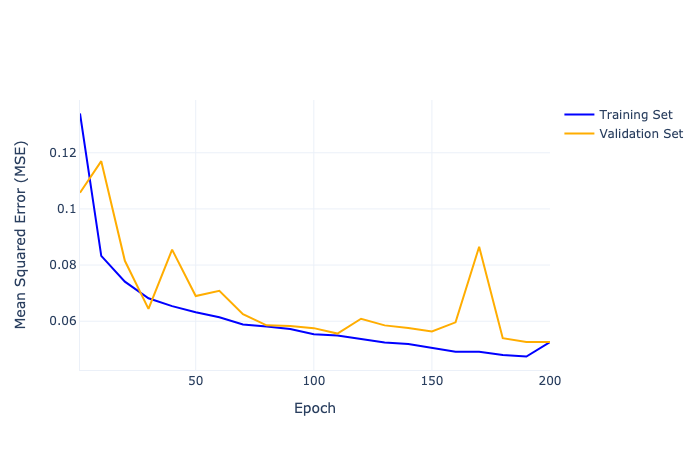

In [206]:
learning_viz(nn_trained)

In [117]:
# load model and make predictions for test set
# load json and create model
with open('final_model_reg.json', 'r') as json_file:
    loaded_model_json = json_file.read()
estimator_loaded = KerasRegressor(
        build_fn=bl_nn(), epochs=100,
        batch_size=5, verbose=1
    )
estimator_loaded.model = model_from_json(loaded_model_json)
# load weights
estimator_loaded.model.load_weights("final_model_reg.h5")
# load scaler
sc=load('final_scaler.bin')

In [182]:
X_test_st_loaded = sc.transform(X_test)
nn_preds_loaded = estimator_loaded.predict(X_test_st_loaded)
final_preds_nn_loaded = np.exp(nn_preds_loaded)

3526/3526 [==============================] - 3s 914us/step


In [187]:
final_preds_nn_loaded.index

RangeIndex(start=0, stop=17626, step=1)

In [185]:
X_test.shape

(17626, 33)

In [189]:
# More in depth, let's look at the errors for each offering type
final_preds_nn_loaded = pd.Series(final_preds_nn_loaded)
nn_preds_loaded = pd.Series(nn_preds_loaded)
final_preds_nn_loaded.index = X_test.index
nn_preds_loaded.index = X_test.index
nn_preds_loaded_sale = nn_preds_loaded[X_test.index[X_test.offering_type_id == 1]]
nn_preds_loaded_rent = nn_preds_loaded[X_test.index[X_test.offering_type_id == 2]]
final_preds_nn_loaded_sale = final_preds_nn_loaded[
    X_test.index[X_test.offering_type_id == 1]]
final_preds_nn_loaded_rent = final_preds_nn_loaded[
    X_test.index[X_test.offering_type_id == 2]]

In [199]:
print(
    "RMSE All listings: ",
    round(sqrt(mean_squared_error(np.exp(y_test), final_preds_nn_loaded)), 2),
    "AED")
print(
    "RMSE Sale: ",
    round(sqrt(mean_squared_error(y_test_sale, final_preds_nn_loaded_sale)), 2),
    "AED")
print(
    "RMSE Rent: ",
    round(sqrt(mean_squared_error(y_test_rent, final_preds_nn_loaded_rent)), 2),
    "AED")

RMSE All listings:  864427.56 AED
RMSE Sale:  1189183.92 AED
RMSE Rent:  46080.02 AED


In [195]:
# Add MAPE error for correct comparison between offering types

print(
    "MAPE All listings: ",
    round(
        np.mean(
            np.abs(
                (np.exp(y_test) - final_preds_nn_loaded) / np.exp(y_test))
        ) * 100,
        2),
    "%")
print(
    "MAPE Sale: ",
    round(
        np.mean(
            np.abs(
                (y_test_sale - final_preds_nn_loaded_sale) / y_test_sale)
        ) * 100,
        2),
    "%")
print(
    "MAPE Rent: ",
    round(
        np.mean(
            np.abs(
                (y_test_rent - final_preds_nn_loaded_rent) / y_test_rent)
        ) * 100,
        2),
    "%")

MAPE All listings:  17.94 %
MAPE Sale:  16.86 %
MAPE Rent:  19.15 %


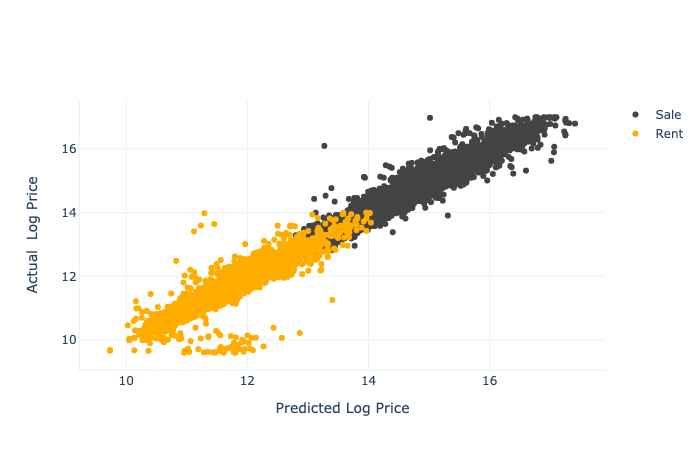

In [210]:
fig = go.Figure()
fig = fig.update_layout(
    template="plotly_white",
    xaxis={
        "title": "Predicted Log Price"
    },
    yaxis={
        "title": "Actual  Log Price"
    }
)
fig = fig.add_trace(
    go.Scatter(
        x=nn_preds_loaded_sale,
        y=np.log(y_test_sale),
        mode='markers',
        name='Sale',
        line=dict(color='#444444')
    )
)
fig = fig.add_trace(
    go.Scatter(
        x=nn_preds_loaded_rent,
        y=np.log(y_test_rent),
        mode='markers',
        name='Rent',
        line=dict(color='#ffad00')
    )
)

fig.show('png')

In [224]:
X_test.columns

Index(['offering_type_id', 'bedroom_id', 'bathroom_id', 'property_log_sqft',
       'property_cheques', 'valid_period', 'before_oct_27th_2018',
       'oct_27th_2018', 'oct_28th_2018', 'oct_29th_2018', 'oct_30th_2018',
       'oct_31th_2018', 'metro_poi', 'tram_poi', 'expo_2020_site',
       'marina_mall', 'hamdan_sports_complex', 'motor_city', 'jabel_ali',
       'img_world_adventures', 'dubai_parks_and_resorts',
       'dubai_cycling_course', 'sports_city_and_dubai_swimming_academy',
       'downtown_dubai', 'global_village', 'dubai_mall', 'mirdif_city_centre',
       'ibn_battuta_mall', 'burj_al_arab', 'dubai_internatial_airport_(dxb)',
       'al_maktoum_international_airport_(dwc)', 'mall_of_the_emirates',
       'burj_khalifa'],
      dtype='object')

###  3.3.2 Conclusions

1. The Neural Network outperforms the initial linear regression:
   - RMSE Comparison:

         a. All listings: 864,427 AED (Neural Network) and 1,129,333 AED (Linear Regression)
         b. Sale: 1,189,184 AED (Neural Network) and 1,553,136 AED (linear Regression)
         c. Rent: 46,080 AED (Neural Network) and 72,629 AED (linear Regression)
         
2. This tuning of this model is not for optimal learning. With more time it can be improved.
3. There seems to be some outliers still. Is the same issue I discussed for the linear model, perhaps if more
information about the listing were to be used, like amenities (I saw this type on info in the Property finder website
but is not provided in the dataset). This could help identify the luxury rents with extremely low AED/year.

## 3.4  Classification Models

### 3.4.1 Distribution of the target variable, the percentage of listings transacted after a month (By offering type)

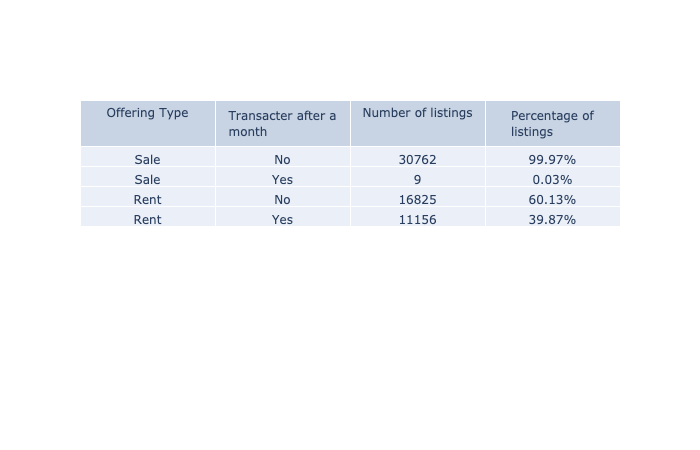

In [304]:
grp_perc_1 = pd.pivot_table(
    listings_df.loc[listings_df.offering_type_id == 1],
    index=['offering_type_id', 'transacted_after_a_month'],
    values='web_id', aggfunc=len, 
    margins=True).div(
    len(listings_df.loc[
        listings_df.offering_type_id == 1].index)
).reset_index()
grp_perc_2 = pd.pivot_table(
    listings_df.loc[listings_df.offering_type_id == 2],
    index=['offering_type_id','transacted_after_a_month'],
    values='web_id', aggfunc=len, 
    margins=True).div(
    len(listings_df.loc[listings_df.offering_type_id == 2].index)
).reset_index()
grp_perc = pd.concat([grp_perc_1, grp_perc_2])
grp_perc = grp_perc.loc[grp_perc.offering_type_id != 'All']
grp_perc.replace({'offering_type_id': {1: 'Sale', 2: 'Rent'}},
                 inplace=True)
grp_perc.replace({'transacted_after_a_month': {0: 'No', 1: 'Yes'}},
                 inplace=True)
all_listings = listings_df.groupby('offering_type_id').agg({'web_id': 'count'}).reset_index()
all_listings.replace(
    {'offering_type_id': {1: 'Sale', 2: 'Rent'}},
    inplace=True)
grp_perc = grp_perc.merge(all_listings, on='offering_type_id')
grp_perc['web_id'] = grp_perc['web_id_x'] * grp_perc['web_id_y']
fig = go.Figure(
    data=[
        go.Table(
            header=dict(
                values=[
                    'Offering Type',
                    'Transacted after a month',
                    'Number of listings',
                    'Percentage of listings']),
            cells=dict(
                values=[
                    grp_perc.offering_type_id,
                    grp_perc.transacted_after_a_month,
                    grp_perc.web_id,
                    grp_perc.web_id_x
                ],
                format=[None, None, None, ".2%"]
            )
        )
    ]
)
fig.show('png')

In [301]:
all_listings = listings_df.groupby('offering_type_id').agg({'web_id': 'count'}).reset_index()
all_listings.replace(
    {'offering_type_id': {1: 'Sale', 2: 'Rent'}},
    inplace=True)
grp_perc = grp_perc.merge(all_listings, on='offering_type_id')
grp_perc['web_id'] = grp_perc['web_id_x'] * grp_perc['web_id_y']
fig = go.Figure(
    data=[
        go.Bar(
            x=grp_perc.loc[
                grp_perc.offering_type_id == 'Sale',
                'transacted_after_a_month'],
            y=(grp_perc.loc[
                grp_perc.offering_type_id == 'Sale',
                'web_id'] *
               all_listings.loc[
                   all_listings.offering_type_id == 1,
                   'web_id']),
            name='Sale'
        ),
        go.Bar(
            x=grp_perc.loc[
                grp_perc.offering_type_id == 'Rent',
                'transacted_after_a_month'],
            y=(grp_perc.loc[
                grp_perc.offering_type_id == 'Rent',
                'web_id'] *
               all_listings.loc[
                   all_listings.offering_type_id == 2,
                   'web_id']),
            name='Rent'
        )
    ],
                
)
fig_table = go.Figure(
    data=[
        go.Table(
            header=dict(
                values=[
                    'Offering Type',
                    'Transacted after a month',
                    'Number of listings']),
            cells=dict(
                values=[
                    grp_perc.offering_type_id,
                    grp_perc.transacted_after_a_month,
                    grp_perc.web_id
                ],
                format=[None, None, ".2%"]
            )
        )
    ]
)
fig_table.show('png')

offering_type_id transacted_after_a_month  web_id_x  web_id_y     web_id
0             Sale                       No    0.9997     30771 30762.0000
1             Sale                      Yes    0.0003     30771     9.0000
2             Rent                       No    0.6013     27981 16825.0000
3             Rent                      Yes    0.3987     27981 11156.0000

In [307]:
# get data from postgresql
conn = create_engine("postgres://{user}:{pw}@{host}:{port}/{db}".format(
    user=user, pw=pw, host=host, port=port, db=db))
query_listings = "select * from listings"
listings_df2 = pd.read_sql_query(
    query_listings,
    conn,
    parse_dates=['meta_valid_from_dts', 'meta_valid_to_dts'])

In [310]:
# Make sure no listings for apartment sales that were transacted after a month
# were excluded for the regression
listings_df2.loc[(listings_df2.transacted_after_a_month == 1) &
                 (listings_df2.offering_type_id == 1)].shape

(9, 15)

#### 3.4.1.1 Conclusion
There is a class imbalance problem for the apartment for sale with only 9 (0.03%) listings transacted after a month.
For the moment I will start with a classification model for rent and if there is time I will handle the sale
classification issue.

### 3.4.2 Rent classification models

#### 3.4.2.1 Baseline logistic

In [320]:
# Split in train/test again, add the price as feature
rent_df = listings_df.loc[listings_df.offering_type_id == 2]
y = rent_df.transacted_after_a_month
X = rent_df[new_covs + ['property_log_price']]

X_train, X_test, y_train, y_test = train_test_split(
                          X, y, random_state=32, test_size=.30)

In [348]:
log_reg = linear_model.LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
preds_lgst = log_reg.predict(X_test)
print('Accuracy : {:.2f}'.format(log_reg.score(X_test, y_test)))

Accuracy : 0.99


In [349]:
confusion_matrix = confusion_matrix(y_test, preds_lgst)
print(confusion_matrix)

[[5058   20]
 [  51 3266]]


In [350]:
print(classification_report(y_test, preds_lgst))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      5078
         1.0       0.99      0.98      0.99      3317

    accuracy                           0.99      8395
   macro avg       0.99      0.99      0.99      8395
weighted avg       0.99      0.99      0.99      8395



In [343]:
fpr, tpr, thresholds = roc_curve(y_test, log_reg.predict(X_test))

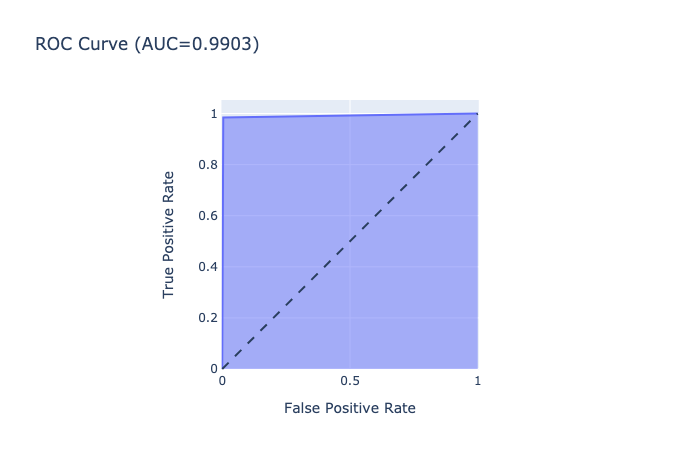

In [345]:
fig_auc = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig_auc.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig_auc.update_yaxes(scaleanchor="x", scaleratio=1)
fig_auc.update_xaxes(constrain='domain')
fig_auc.show('png')

##### 3.4.2.1.1 Conclusions
The results look too good to be true, but then again this is data unseen to the model. I will add a cross-validation
just to be sure. Nevertheless, I would say this simple model is good enough for the rent classification task.

#### 3.4.2 Cross-validated Logistic regression using elastic net penalty and 10 folds

In [359]:
cv_logreg = linear_model.LogisticRegressionCV(
    cv=10, random_state=0,penalty='elasticnet', l1_ratios=[0.5],
    solver='saga',
    max_iter=10000).fit(X_train, y_train)
cv_logreg.fit(X_train, y_train)
preds_lgst = cv_logreg.predict(X_test)
print('Accuracy : {:.2f}'.format(cv_logreg.score(X_test, y_test)))

Accuracy : 1.00


In [360]:
print(classification_report(y_test, preds_lgst))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5078
         1.0       1.00      0.99      0.99      3317

    accuracy                           1.00      8395
   macro avg       1.00      1.00      1.00      8395
weighted avg       1.00      1.00      1.00      8395



### Cross-validated logistic regression with l1 and l2 penalizers
The CV model produces even better results with only one metric below 1:
The recall (sensitivity in this case) is 0.99 this means that 1% of the listings
are incorrectly labeled as not being transacted after a month.


## 3.5 Final remarks
I didn't have enough time to look at the issue for sale classification, but then again nine points seems insufficient.
There are techniques for oversampling like the Synthetic Minority Over-sampling Technique (SMOTE).
Now, the issue is that I would still need to take some of these nine points for the test set (let's say three). Then
oversampling from the distribution of six listings seems inappropriate, at least from a statistical point of view.
I would rather say that these are extreme cases (I can see some listings look like whole buildings), and there
is no point of trying to build a classification model for them in particular. Maybe if they are combined with
commercial sale that would make more sense, but I only have apartments in this dataset.